In [1]:
import pandas as pd
import numpy as np
!pip install dtreeviz
!apt-get install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 329 kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


**tabular modeling**

lets load our data and have a look at the columns

In [2]:
df = pd.read_csv('/TrainAndValid.csv')

In [3]:

from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import matplotlib.pyplot as plt



In [4]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [5]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

we can tell Pandas about a suitable ordering of these levels(classes) like so:

In [6]:
sizes = 'Large', 'Large / Medium', 'Small', 'Mini', 'Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered = True, inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


the dependant variable

In [7]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

the 'SaleDate' column

In [8]:
df = add_datepart(df, 'saledate')

let's do the same for the test set

In [9]:
df_test = pd.read_csv('/Test.csv', low_memory = False)
df_test = add_datepart(df_test, 'saledate')

we can see that there are now lots of new columns in our DataFrame

In [10]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

using TabularPandas and TabularProc

In [11]:
procs = [Categorify, FillMissing]

#categorify is a TabularProc that replaces a column with a numeric categorical column
#FillMissing is a TabularProc that replaces missing values with the median of the column , and creates a new Boolean column that is set ti True for any row where the value was missing

In [12]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

In [13]:
splits = (list(train_idx), list(valid_idx))

In [14]:
cont, cat = cont_cat_split(df, 1, dep_var = dep_var)
#cont, cat
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [15]:
len(to.train), len(to.valid)

(23815, 1056)

In [16]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,1139246,999089,3157,121,3,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,#na#,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,1139248,117657,77,121,3,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,1139249,434808,7009,121,3,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [17]:
to.items.head(3)


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,121,3,2004,68.0,2,524,...,3,320,1,1,1,1,1,1,1.163635e+09,1
1,1139248,10.950807,117657,77,121,3,1996,4640.0,2,960,...,4,86,1,1,1,1,1,1,1.080259e+09,1
2,1139249,9.210340,434808,7009,121,3,2001,2838.0,1,179,...,3,57,1,1,1,1,1,1,1.077754e+09,1


creating the decision tree

In [18]:
xs, y = to.train.xs, to.train.y
valid_xs , valid_y = to.valid.xs, to.valid.y

In [57]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

to keep it simple, we've told sklearn to create just four leaf nodes. To see what it's learned , we can display the tree

In [58]:
#xs.columns
y

0        11.097410
1        10.950807
2         9.210340
3        10.558414
4         9.305651
           ...    
24866     9.680344
24867     9.305651
24868     9.648595
24869     9.581903
24870     9.680344
Name: SalePrice, Length: 23815, dtype: float32

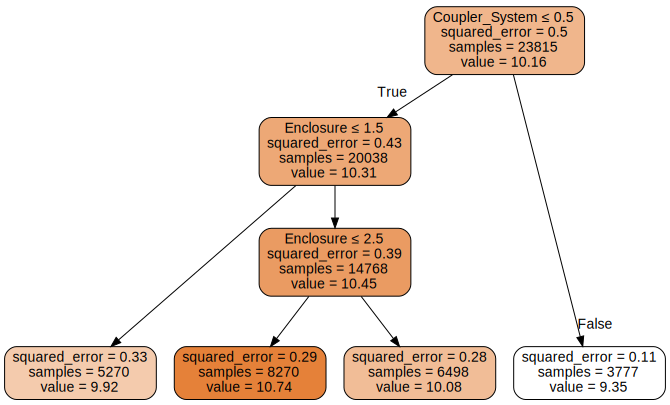

In [59]:
from sklearn.tree import export_graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=0, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)   

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


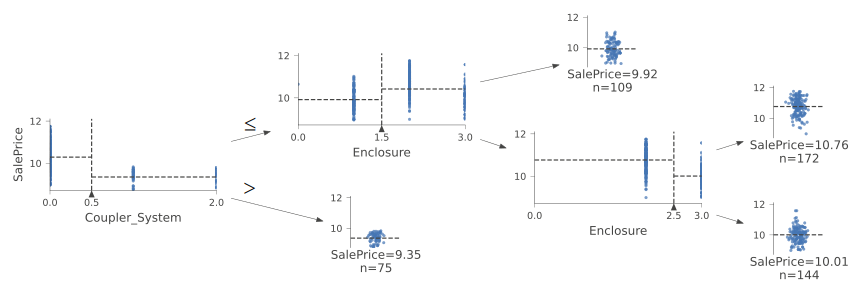

In [22]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
         fontname = 'DejaVu Sans', scale= 1.6, label_fontsize= 10,
         orientation = 'LR')

we can see a problem with the YearMade feature

In [23]:
xs.loc[xs['YearMade']<1900, 'YearMade']= 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade']= 1950

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


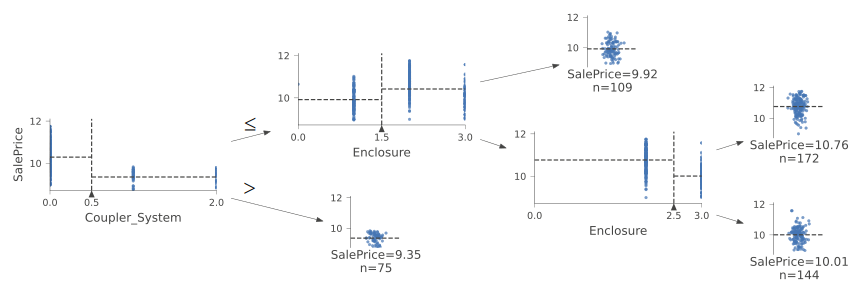

In [24]:
m=DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
         fontname='DejaVu Sans', scale = 1.6, label_fontsize=10,
         orientation = 'LR')

le

let's now have the decision tree algorithm build a bigger tree.

In [25]:
m = DecisionTreeRegressor()
m.fit(xs, y)

DecisionTreeRegressor()

we'll create a little function to check the root mean squared error of our model (m_rmse), sicnce that's how the competition was judged:

In [26]:
def r_rmse(pred, y): return round(math.sqrt(((pred - y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_rmse(m.predict(xs), y)
m_rmse(m, xs, y)

0.0

so, our model is perfect, right? Not so fast ...remember , we really need to check the validation set, to ensure we're not overfitting:

In [27]:
m_rmse(m , valid_xs, valid_y)

0.370758

it looks like we might be overfitting pretty badly.And here's why:

In [28]:
m.get_n_leaves(), len(xs)

(20183, 23815)

We have nearly as many leaf nodes as data points !!

Let's change the stopping rule to tell sklearn to ensure every leaf node contains at least 25 records:

In [60]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.253769, 0.315861)

Let's check the number of leaves again:

In [30]:
m.get_n_leaves()

732

**Creating a Random Forest**

In [61]:
def rf(xs, y, n_estimators= 40, max_samples=200_00,
       max_features= 0.5, min_samples_leaf=5, **kwargs):
  return RandomForestRegressor(n_jobs = -1, n_estimators=n_estimators,
                               max_samples=max_samples, max_features= max_features,
                               min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)
m = rf(xs, y)

In [62]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.167372, 0.27255)

To see the impact of n_estimators , let's get the eprediction from each individual tree in our forest :

In [36]:
preds =  np.stack([t.predict(valid_xs)for t in m.estimators_])
preds

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature nam

array([[ 9.7526518 , 10.28019273,  9.21423276, ..., 11.14818978,
        11.14818978,  9.45866489],
       [10.55839517,  9.97139178,  9.37468926, ..., 11.04499578,
        11.04499578,  9.24769974],
       [ 9.80783498, 10.12744882,  9.39910002, ..., 11.24484666,
        11.24484666,  9.03408493],
       ...,
       [ 9.87886514, 10.04173594,  9.46355605, ..., 11.25680038,
        11.25680038,  9.10670843],
       [10.15213642, 10.10548814,  9.27372675, ..., 11.2492214 ,
        11.2492214 ,  9.17480087],
       [ 9.73335478,  9.79617732,  9.51047584, ..., 11.26551714,
        11.26551714,  9.09867652]])

In [37]:
r_rmse(preds.mean(0), valid_y)

0.277268

Let's see what happens to the RMSE as we add more and more trees:

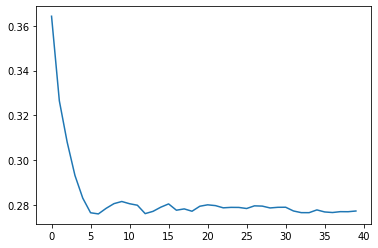

In [38]:
plt.plot([r_rmse(preds[:i+1].mean(0), valid_y)for i in range(40)])

**out-of-Bag Error**

the oob error is a way of measuring prediction error in the training dataset by including in the calculation of row's error trees only where that row was not included in ttraining .This allows  us to see whether the model is overfitting , without needing a separate validationo set.

In [39]:
r_rmse(m.oob_prediction_, y)

0.234853

**Model Interpretation**

    1)Tree variance for prediction confidence

In [40]:
preds.shape

(40, 1056)

In [41]:
preds_std = preds.std(0)

In [42]:
preds_std[:5]

array([0.32643696, 0.12935971, 0.10944556, 0.22742581, 0.22338335])

    2)Feature Importance

In [63]:
def rf_feat_importance(m, df):
  return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [64]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
30,Coupler_System,0.131353
56,YearMade,0.119944
12,Enclosure,0.112498
7,fiProductClassDesc,0.093622
31,Grouser_Tracks,0.065769
6,ProductSize,0.064430
3,fiSecondaryDesc,0.045758
32,Hydraulics_Flow,0.045541
53,ModelID,0.037976
1,fiModelDesc,0.027938


A plot of the feature importances shows the relative importances more clearly:

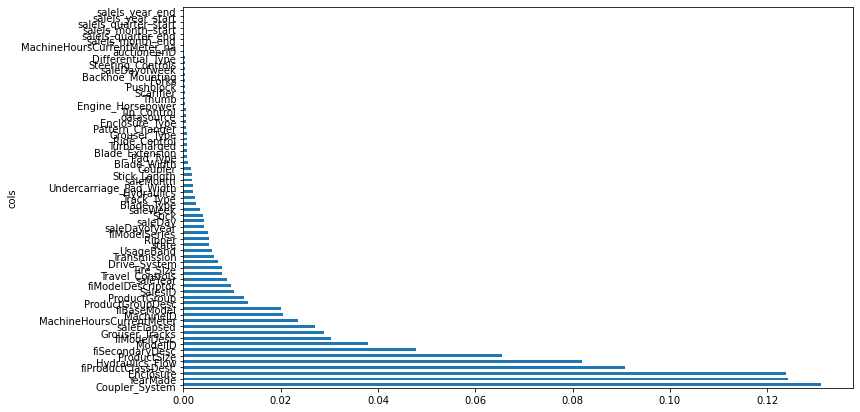

In [45]:
def plot_fi(fi):
  return fi.plot('cols', 'imp', 'barh', figsize=(12, 7), legend = False)

plot_fi(fi)

Removing low-importance Variables 

lets try keeeping just those with a feature importance grater than 0.005

In [46]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

27

we can retrain our our model using just this subset of the columns:


In [47]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [48]:
m = rf(xs_imp, y)

In [49]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.170337, 0.270313)

In [50]:
len(xs.columns), len(xs_imp.columns)

(65, 27)

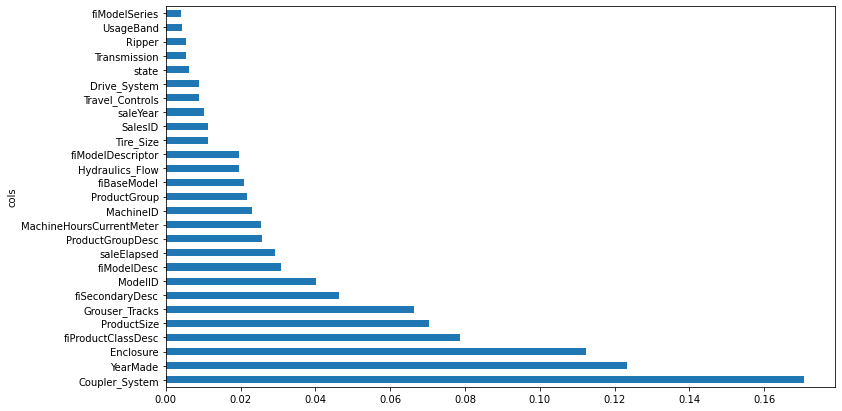

In [51]:
plot_fi(rf_feat_importance(m, xs_imp))

removing redundant features 

In [53]:
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

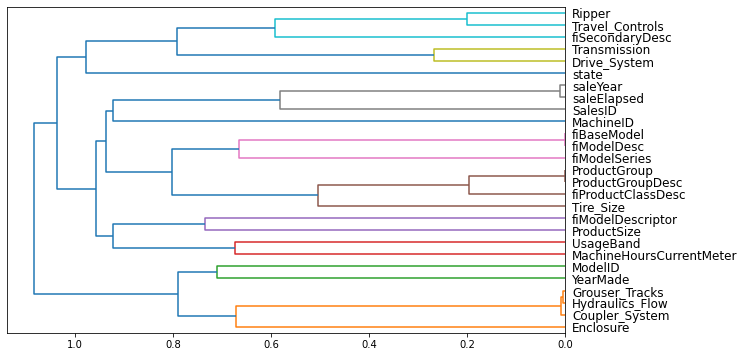

In [55]:
cluster_columns(xs_imp)

In [65]:
def get_oob(df):
  m = RandomForestRegressor(n_estimators = 40, min_samples_leaf=15,
                            max_samples= 5000, max_features=0.5, n_jobs = -1, oob_score= true)
  m.fit(df, y)
  return m.oob_score_

Here's our baseline

In [67]:
get_oob(xs_imp)

0.8379208945223564

Now we try removing each of our potentially redundant variables , one at a time:


In [69]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in(
    'saleYear', 'saleElapsed', 'ProductGroupDesc', 'ProductGroup',
    'fiModelDesc', 'fiBaseModel', 
    'Hydraulics_Flow', 'Grouser_Tracks', 'Coupler_System'
)}

{'saleYear': 0.8389443583596221,
 'saleElapsed': 0.8349031375507131,
 'ProductGroupDesc': 0.8420171097727619,
 'ProductGroup': 0.835690325450237,
 'fiModelDesc': 0.838566088636584,
 'fiBaseModel': 0.8388812577753011,
 'Hydraulics_Flow': 0.8407526587961389,
 'Grouser_Tracks': 0.8401784214742992,
 'Coupler_System': 0.838801688856962}

Now let's try dropping multiple variables. We'll drop one from each of the tightly aligned pairs we noticed earlier.Let's see what that does:


In [70]:
to_drop =['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.835964953649565

Looking good!This is really not much worse than the model with all the fields.Let's create DataFrame without these columns, and save them:

In [71]:
xs_final = xs_imp.drop(to_drop, axis =1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis = 1)

Now we can check our RMSE again, to confirm that th eaccuracy hasn't substanyially changed:

In [72]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.17504, 0.279938)

**Partial adependence**

As we have seen , the two most important predictors are ProductSIze and YearMade.We'd like to understand the relationship between these predictors and the sale price.It's a good idea to first check theh count of values per category to see how common each category is:

([<matplotlib.axis.YTick at 0x7fe41393f790>,
 [Text(0, 0, '#na#'),
  Text(0, 0, 'Large'),
  Text(0, 0, 'Large / Medium'),
  Text(0, 0, 'Small'),
  Text(0, 0, 'Mini'),
  Text(0, 0, 'Compact')])

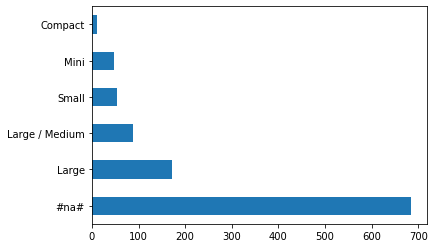

In [73]:
p = valid_xs_final['ProductSize'].value_counts(sort= False).plot.barh()
c= to.classes['ProductSize']
plt.yticks(range(len(c)), c)

Let's do the same thing for YearMade

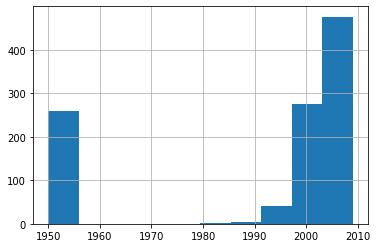

In [74]:
ax = valid_xs_final['YearMade'].hist()

In [75]:
from sklearn.inspection import plot_partial_dependence

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


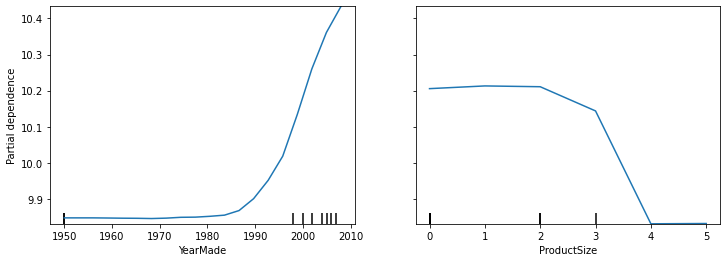

In [77]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m , valid_xs_final, ['YearMade', 'ProductSize'],
                        grid_resolution = 20, ax=ax)

In [92]:
!pip install treeinterpreter
!pip install waterfallcharts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [93]:
from treeinterpreter import treeinterpreter as ti
from waterfallcharts import waterfall_chart 

ModuleNotFoundError: ignored

In [79]:
row = valid_xs_final.iloc[:5]

In [88]:
prediction, bias, contributions = ti.predict(m, row.values)

In [89]:
prediction[0], bias[0], contributions[0].sum()

(array([9.9345526]), 10.157915662534238, -0.2233630646608336)